# MNIST with MLP in JAX

In [1]:
import jax
import jax.numpy as np
import math
import numpy as onp
import tensorflow as tf
import time
import matplotlib.pyplot as plt

/Users/steve/.local/share/virtualenvs/teaching-kL1iKbCK/lib/python3.8/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In JAX, we need to create a key for all random operations. This is necessary to make random number generation reproducible, parallelizable, and vertorizable (see [here](https://jax.readthedocs.io/en/latest/jax-101/05-random-numbers.html)). 

We will use the `jax.random.split` function to create new keys from this single starting key (see later).

In [2]:
key = jax.random.PRNGKey(1)

We begin by loading the MNIST data as numpy arrays, using keras. 

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

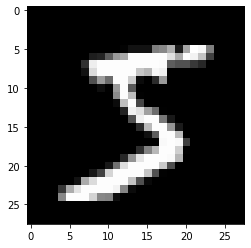

In [4]:
plt.imshow(x_train[0], cmap='gray')

In [5]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

As we are using an MLP, we need to flatten the images to 1D vectors. We simultaneously also normalize the pixel values to lie in $[0,1]$.

In [6]:
x_train = x_train.reshape(-1, 28*28) / 255.
x_test = x_test.reshape(-1, 28*28) / 255.

We also need to one-hot-encode our labels

In [7]:
def one_hot(x, k, dtype=np.float32):
  return np.array(x[:, None] == np.arange(k), dtype)

In [8]:
y_train = one_hot(y_train, 10)
y_test = one_hot(y_test, 10)

In [9]:
y_train.shape

(60000, 10)

In [10]:
y_train[:5]

DeviceArray([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
             [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
             [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

## Initializing the MLP

Let's begin by defining out nonlinear activation function, the relu function.

In [11]:
def relu(x):
    return np.maximum(x, 0)

For an MLP layer with input $x \in \mathbb{R}^{n}$ and output $y \in \mathbb{R}^m$, we have the following equation for the forward pass (or prediction):
$$
y = f(Wx+b)
$$
where $f$ is the nonlinear activation function which is typically applied element-wise (we are using `relu`, defined above), $W$ is the weight matrix with $W \in \mathbb{R}^{m \times n}$, and $b$ is the bias vector $\mathbb{R}^m$. 

We define a function that randomly initializes the parameters (weight matrix and bias vector) of a given connection layer:

In [12]:
def init_layer(in_dim, out_dim, key, scale=1e-2):
    w_key, b_key = jax.random.split(key)  # split the key for weight and bias
    w = jax.random.normal(w_key, (out_dim, in_dim))
    b = jax.random.normal(b_key, (out_dim,))
    return scale * w, scale * b

Now, we can define a simple function that initializes all parameters for a MLP from a list of layer sizes. For example, to generate the parameters of a MLP with input layer size 10, hidden layer size 100, and output layer size 1, we could run `init_network_params([10, 100, 1], key)` (where `key` is our random key).

In [13]:
def init_network_params(sizes, key):
  keys = jax.random.split(key, len(sizes)-1)
  layers = []
  for idx in range(len(sizes) - 1):
    layers.append(
      init_layer(in_dim=sizes[idx], out_dim=sizes[idx+1], key=keys[idx])
    )
  return layers

We can make this code more concise:

In [14]:
def init_network_params(sizes, key):
  keys = jax.random.split(key, len(sizes)-1)
  return [init_layer(in_dim=a, out_dim=b, key=k) for a, b, k in zip(sizes[:-1], sizes[1:], keys)]

Let's make sure the dimensions are as expected:

In [15]:
layer_sizes = [784, 512, 512, 10]
params = init_network_params(layer_sizes, key)

In [16]:
for i, (w, b) in enumerate(params):
    print(f'layer {i}: w {w.shape}\tb {b.shape}')

layer 0: w (512, 784)	b (512,)
layer 1: w (512, 512)	b (512,)
layer 2: w (10, 512)	b (10,)


Now we can write the forward pass equations for the network. Note that the output layer will not have the standard activation function, but instead we will apply the [softmax function](https://en.wikipedia.org/wiki/Softmax_function).

In [17]:
def softmax(x):
    # normalized softmax
    x_norm = x - np.max(x)
    x_exp = np.exp(x_norm)
    return x_exp / np.sum(x_exp)

In [18]:
def forward(params, u):
    # u is the input, x is the activation
    x = u
    # forward pass for all hidden connection layers
    for w, b in params[:-1]:
        out = np.dot(w, x) + b
        x = relu(out)
    # forward pass for the output layer
    w, b = params[-1]
    # compute logits (non-normalized output)
    logits = np.dot(w, x) + b
    # apply softmax
    return softmax(logits)

# vectorize this function to operate on batch
batch_forward = jax.vmap(forward, in_axes=(None, 0))

`in_axes=(None, 0)` specifies that for the `params` argument, we will not vectorize anything (`None`) whereas for the `u` (input data) argument, we will vectorize the argument by adding a new axis at index `0`. This means that if before, we would pass a single MNIST data sample `u` with shape `(784,)` into the `forward` function, we will now pass a batch of `N` MNIST data samples as `u_batch` with shape `(N,784)`.

## Evaluation functions: accuracy and loss

In [19]:
def accuracy(params, x, y_true):
    true = np.argmax(y_true, axis=1)
    pred = np.argmax(batch_forward(params, x), axis=1)
    return np.mean(pred == true)

We use the cross entropy loss function, as defined e.g. in Bishop's "[Pattern Recognition and Machine Learning](https://www.microsoft.com/en-us/research/publication/pattern-recognition-machine-learning/)" book (page 209). Assuming that the prediction of the output distribution $\hat y$ is already normalized with a softmax function (as we did above), the cross entropy loss $L_{CE}$ is computed as:

$$
L_{CE} = - \prod_{n=1}^N \prod_{k=1}^K \hat{y}_{nk}^{y_{nk}}
$$

which, after taking the logarithm, yields:

$$
L_{CE} = - \sum_{n=1}^N \sum_{k=1}^K y_{nk} \log{\hat{y}_{nk}}
$$

where $N$ is the number of data points for which the loss is computed (i.e. the batch size), $K$ is the number of classes ($K=10$ here), and $y$ is the (one-hot encoded) true label of each data point, and where the subscript $nk$ refers to the $k$th output value of the $n$th data point.

In [20]:
def loss(params, x, y_true):
    # cross entropy loss (see Bishop's Pattern Recognition book, page 209).
    y_pred = batch_forward(params, x)
    return -np.sum(np.sum(y_true * np.log(y_pred), axis=1)) / x.shape[0]

We now write the SGD update step:

In [21]:
@jax.jit
def update(params, x, y_true, step_size=1e-2):
    grads = jax.grad(loss)(params, x, y_true)
    new_params = []
    for idx in range(len(params)):
        w, b = params[idx]
        dw, db = grads[idx]
        w_new = w - step_size * dw
        b_new = b - step_size * db
        new_params.append((w_new, b_new))
    return new_params

Which can be written more concisely:

In [22]:
@jax.jit
def update(params, x, y_true, step_size=1e-2):
    grads = jax.grad(loss)(params, x, y_true)
    return [
        (w - step_size * dw, b - step_size * db)
        for (w, b), (dw, db) in zip(params, grads)
    ]

## Training loop

In [23]:
loss(params, x_train, y_train)

DeviceArray(2.3028953, dtype=float32)

In [24]:
n_epochs = 30
batch_size = 128

In [25]:
train_acc = []
test_acc = []
train_loss = []
test_loss = []
for epoch in range(n_epochs):
    start_time = time.time()
    n_batches = math.ceil(x_train.shape[0] / batch_size)
    for batch_idx in range(n_batches):
        start = batch_idx * batch_size
        end = -1 if batch_idx == (n_batches - 1) else start + batch_size
        x_batch = x_train[start:end, :]
        y_batch = y_train[start:end, :]
        params = update(params, x_batch, y_batch, step_size=1e-2)
    epoch_time = time.time() - start_time
    train_acc.append(accuracy(params, x_train, y_train))
    test_acc.append(accuracy(params, x_test, y_test))
    train_loss.append(loss(params, x_train, y_train))
    test_loss.append(loss(params, x_test, y_test))
    print(f'Epoch {epoch+1:>2} ({epoch_time:<.2f}s): ', end='')
    print(f'train loss {train_loss[-1]:<5.2f} test loss {test_loss[-1]:<5.2f}', end='| ')
    print(f'train acc {train_acc[-1]:<7.2%} test acc {test_acc[-1]:<7.2%}')

Epoch  1 (2.14s): train loss 2.29  test loss 2.29 | train acc 18.84%  test acc 19.10% 
Epoch  2 (1.64s): train loss 2.25  test loss 2.25 | train acc 36.49%  test acc 36.57% 
Epoch  3 (1.61s): train loss 1.88  test loss 1.87 | train acc 47.65%  test acc 47.19% 
Epoch  4 (1.61s): train loss 0.99  test loss 0.97 | train acc 71.71%  test acc 72.09% 
Epoch  5 (1.63s): train loss 0.68  test loss 0.66 | train acc 80.24%  test acc 80.59% 
Epoch  6 (1.64s): train loss 0.55  test loss 0.54 | train acc 83.94%  test acc 84.03% 
Epoch  7 (1.61s): train loss 0.48  test loss 0.47 | train acc 85.90%  test acc 86.26% 
Epoch  8 (1.63s): train loss 0.44  test loss 0.43 | train acc 87.19%  test acc 87.48% 
Epoch  9 (1.62s): train loss 0.41  test loss 0.40 | train acc 88.20%  test acc 88.19% 
Epoch 10 (1.68s): train loss 0.39  test loss 0.38 | train acc 88.84%  test acc 88.84% 
Epoch 11 (1.65s): train loss 0.37  test loss 0.36 | train acc 89.32%  test acc 89.47% 
Epoch 12 (1.62s): train loss 0.36  test los

[]

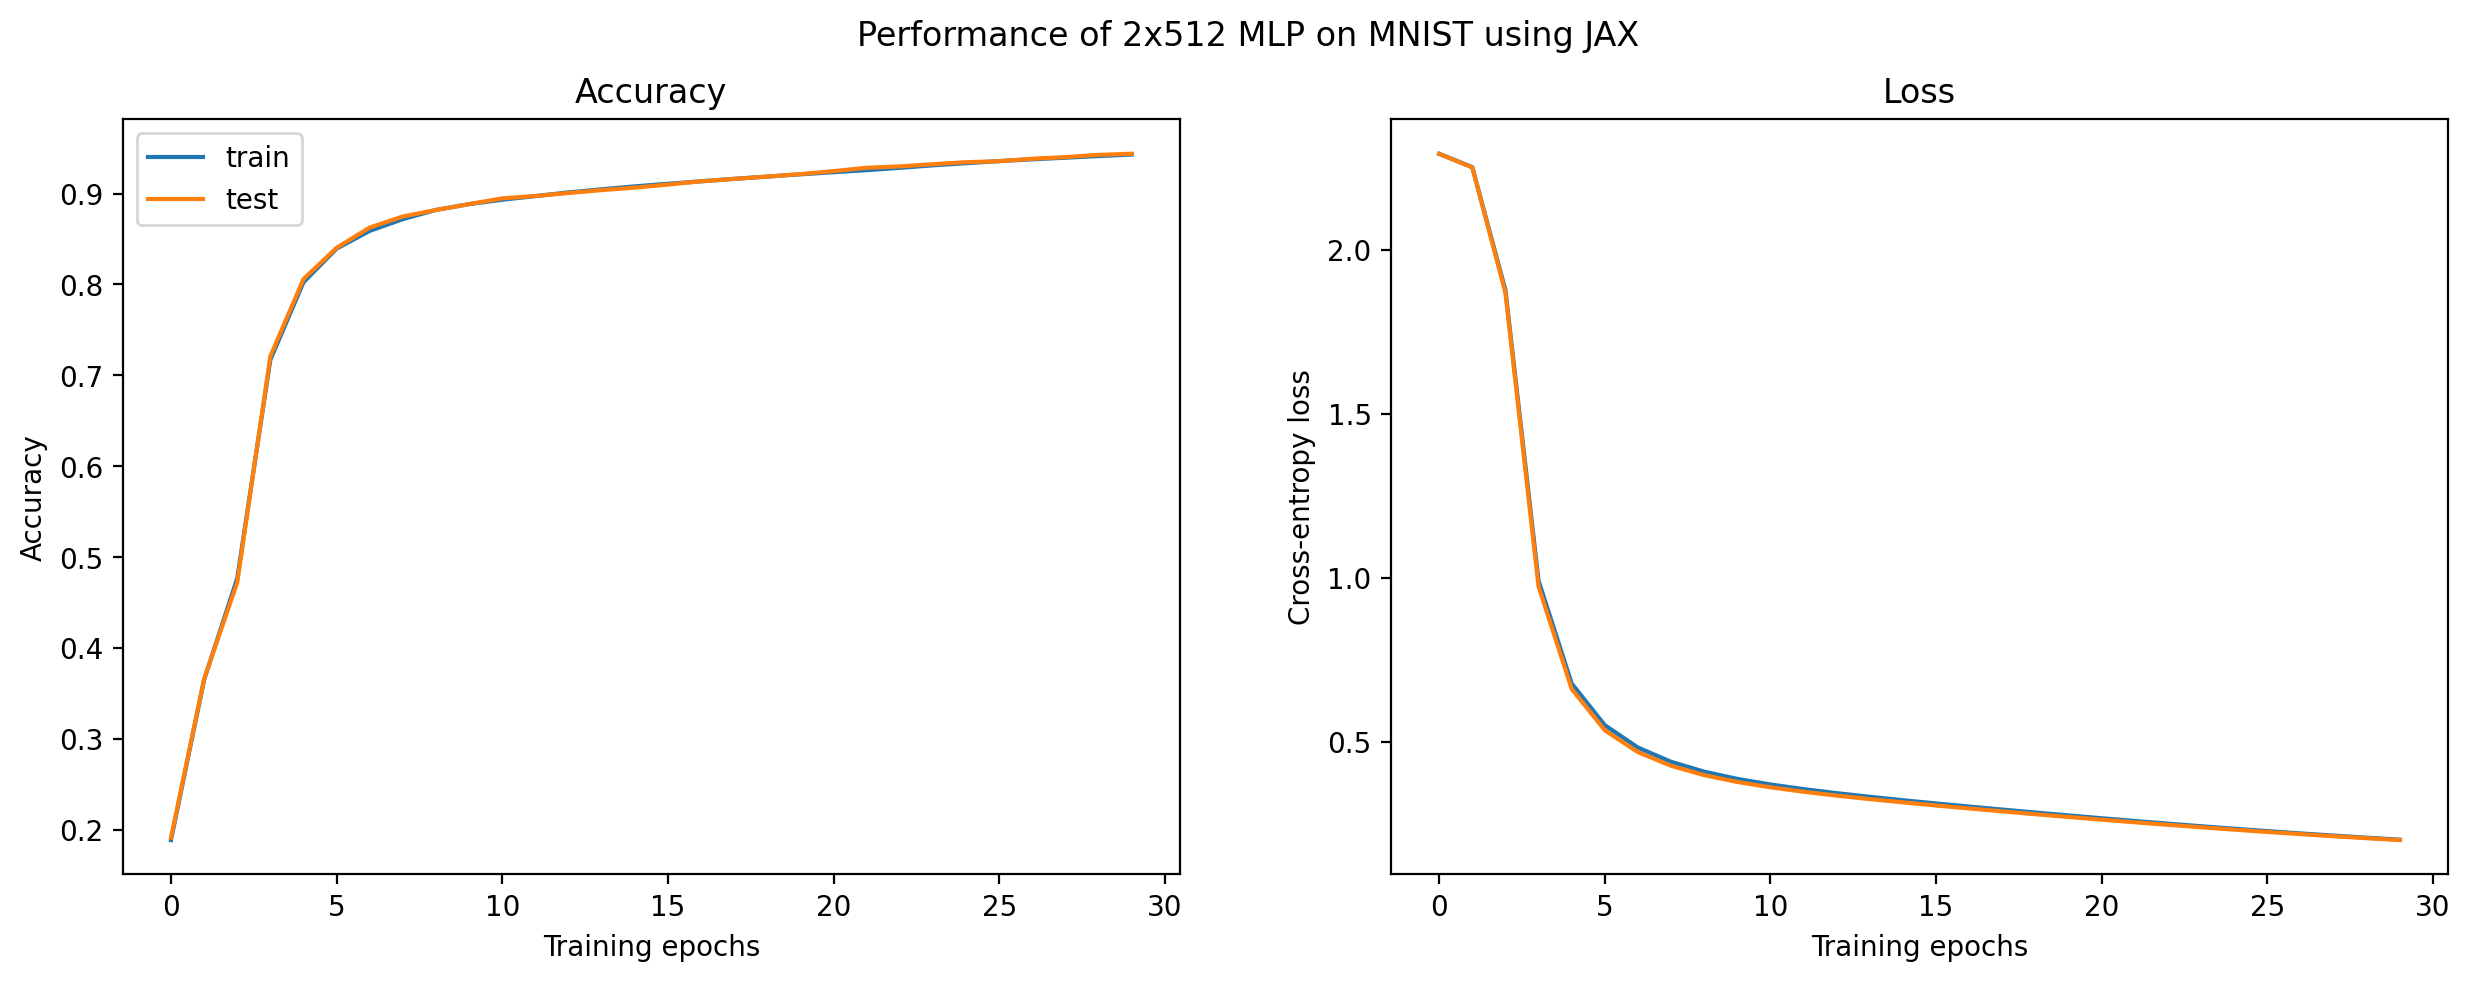

In [28]:
fig, axs = plt.subplots(ncols=2, nrows=1, dpi=200, figsize=(15, 5), sharex=True)
fig.suptitle('Performance of 2x512 MLP on MNIST using JAX')
axs[0].set_title('Accuracy')
axs[0].plot(train_acc, label='train')
axs[0].plot(test_acc, label='test')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Training epochs')
axs[0].legend()
axs[1].set_title('Loss')
axs[1].plot(train_loss, label='train')
axs[1].plot(test_loss, label='test')
axs[1].set_ylabel('Cross-entropy loss')
axs[1].set_xlabel('Training epochs')
plt.plot()

## Further work

In order to really understand and work with the code, I would suggest the following tasks:
- run the code for different architectures and hyperparameters (the `step_size`, or learning rate, is a good starting point, so is the architecture defined in `layer_sizes`, or the nonlinear activation function used)
- implement the network in an `MLP` class rather than passing around the `params` list
- create and use a validation set in the training loop
- using the validation dataset, implement early stopping such that training is stopped when the loss on the validation dataset stops decreasing
- using the validation dataset, run a cross-validation experiment to compare different network architectures and hyperparameters
- implement shuffling for the batches
- use a DataLoader (from PyTorch or Tensorflow)
- improve the optimizer - for example by adding momentum, a learning rate decay, or a learning rate schedule